In [1]:
import autograd 

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

import sys
sys.path.insert(0, '../')

import structure_model_lib
import data_utils
import paragami

import structure_optimization_lib as str_opt_lib

import LinearResponseVariationalBayes.ExponentialFamilies as ef

In [2]:
from BNP_modeling import cluster_quantities_lib, modeling_lib
import BNP_modeling.optimization_lib as opt_lib
import cavi_lib

from itertools import permutations

import matplotlib.pyplot as plt
%matplotlib inline  

import vittles

from copy import deepcopy

In [3]:
np.random.seed(53453)

# Draw data

In [4]:
n_obs = 40
n_loci = 50
n_pop = 4

# population allele frequencies
true_pop_allele_freq = np.random.random((n_loci, n_pop))

# individual admixtures
true_ind_admix_propn = np.random.dirichlet(np.ones(n_pop) / n_pop, size = (n_obs))

In [5]:
clustering_indx = data_utils.cluster_admix_get_indx(true_ind_admix_propn)
true_ind_admix_propn = true_ind_admix_propn[clustering_indx, :]

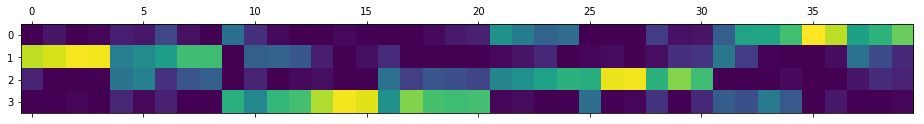

In [6]:
plt.matshow(true_ind_admix_propn.T)

In [7]:
g_obs = data_utils.draw_data(true_pop_allele_freq, true_ind_admix_propn)

In [8]:
g_obs.shape

(40, 50, 3)

# Get prior

In [9]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_free_params = prior_params_paragami.flatten(prior_params_dict, free=True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [10]:
use_logitnormal_sticks = False

In [11]:
k_approx = 6

In [12]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [13]:
vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx, use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (50, 6, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_beta_params] = NumericArrayPattern (40, 5, 2) (lb=0.0, ub=inf)


## Initialize 

In [14]:
vb_params_dict = structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict, 
                                                        use_logitnormal_sticks)

In [15]:
# take a look at init 
if use_logitnormal_sticks: 
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                        vb_params_dict['ind_mix_stick_propn_mean'], 
                        vb_params_dict['ind_mix_stick_propn_info'],
                        gh_loc, gh_weights)

else: 
    # take a look at init 
    ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
    e_stick_lengths = \
            modeling_lib.get_e_beta(ind_mix_stick_beta_params)
    e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])

In [16]:
if k_approx < 6: 
    # find minimizing permutation 
    # only feasible if k_approx is small, 
    # else my computer freezes
    perm = data_utils.find_min_perm(e_pop_freq, true_pop_allele_freq, axis = 1)
else: 
    perm = np.arange(k_approx)
    
e_pop_freq = e_pop_freq[:, perm]
e_ind_admix = e_ind_admix[:, perm]

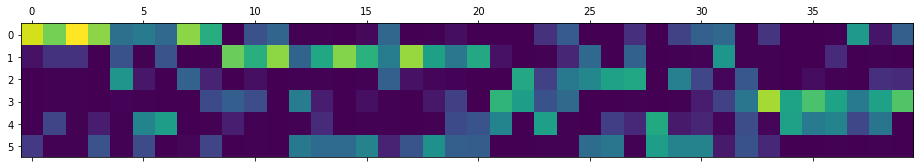

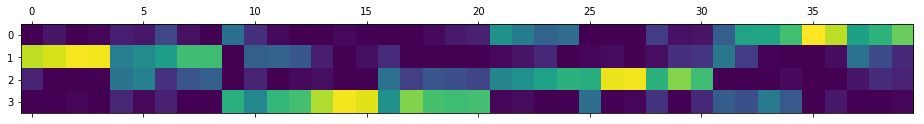

In [17]:
plt.matshow(e_ind_admix.T); 
plt.matshow(true_ind_admix_propn.T);

In [18]:
str_opt_lib.optimize_structure(g_obs, vb_params_dict, vb_params_paragami,
                    prior_params_dict,
                    gh_loc, gh_weights, use_logitnormal_sticks = False,
                    run_cavi = True, cavi_max_iter = 1000, cavi_tol = 1e-2,
                    netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8,
                    approximate_hessian = True)

iteration [0]; kl:3952.608162
iteration [1]; kl:3392.455286
iteration [2]; kl:3303.661196
iteration [3]; kl:3277.030543
iteration [4]; kl:3264.05157
iteration [5]; kl:3255.748158
iteration [6]; kl:3249.762555
iteration [7]; kl:3245.140411
iteration [8]; kl:3241.393956
iteration [9]; kl:3238.246244
iteration [10]; kl:3235.529129
iteration [11]; kl:3233.134617
iteration [12]; kl:3230.989707
iteration [13]; kl:3229.04276
iteration [14]; kl:3227.255823
iteration [15]; kl:3225.600129
iteration [16]; kl:3224.053327
iteration [17]; kl:3222.597673
iteration [18]; kl:3221.218805
iteration [19]; kl:3219.90488
iteration [20]; kl:3218.645959
iteration [21]; kl:3217.433569
iteration [22]; kl:3216.260393
iteration [23]; kl:3215.120061
iteration [24]; kl:3214.007007
iteration [25]; kl:3212.916375
iteration [26]; kl:3211.843963
iteration [27]; kl:3210.786181
iteration [28]; kl:3209.740023
iteration [29]; kl:3208.703039
iteration [30]; kl:3207.673314
iteration [31]; kl:3206.649453
iteration [32]; kl:32

array([1.54636412, 3.17695528, 2.98617091, 1.17333721, 0.88048866,
       2.20963723, 1.3719535 , 0.63888827, 0.36176091, 0.35249458,
       2.75397693, 1.47343307, 1.89546985, 3.09319531, 2.34315746,
       2.45895111, 0.63675951, 2.35457854, 0.17771285, 1.59785563,
       0.29820546, 0.40525971, 1.50363113, 2.72682237, 2.87325106,
       2.36617215, 2.55256958, 2.24941557, 2.23287295, 0.89059867,
       1.17799733, 0.97658425, 0.33832979, 0.39326483, 1.50149754,
       2.7903989 , 1.56543395, 3.17645223, 1.63998398, 2.8749999 ,
       1.64222303, 1.88609973, 0.2299269 , 1.59466737, 0.33559069,
       0.38362089, 2.1085446 , 2.4270219 , 1.19644163, 3.17515408,
       3.04506951, 0.82460487, 1.18032503, 2.12238619, 1.58660342,
       0.19043062, 0.39127093, 0.29628743, 2.89363156, 1.05877794,
       3.07501401, 1.85818693, 2.72399499, 2.01077206, 1.69499542,
       1.90111503, 1.42654868, 0.61740837, 0.36569664, 0.36577586,
       2.08645254, 2.49565826, 0.87935925, 3.25434679, 2.90213